# **Clasificación de Dígitos Manuscritos - Análisis y Entrenamiento de Modelos Supervisados**

---

## **1. Descripción del problema y del conjunto de datos**

Este proyecto aborda un problema de **clasificación de imágenes**, específicamente la **identificación de dígitos manuscritos** (del 0 al 9) a partir de imágenes en escala de grises.  
El objetivo es construir **modelos de aprendizaje supervisado** capaces de predecir correctamente el dígito que representa cada imagen.

El conjunto de datos proviene de la plataforma **Kaggle** y contiene imágenes de **28x28 píxeles**, cada una representada como una fila con **784 características** (una por píxel), más una columna `label` que indica el dígito correcto.

---

### **Variables:**

- **label:**  
  Entero entre 0 y 9 que representa el dígito manuscrito.

- **pixel0 a pixel783:**  
  Valores entre 0 y 255 que indican la intensidad de cada píxel.

---

Este conjunto de datos es **ampliamente utilizado** para tareas de clasificación de imágenes debido a su simplicidad y relevancia en problemas reales de **visión por computador**.

In [7]:
# Importar todas las librerías necesarias
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import warnings
import time
# Librerías de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
import seaborn as sns

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
# Configurar el directorio de datos
data_dir = "C:/Users/Camilo/pictures/handwritten-digits-0-9" #cambia esto por tu directorio de datos

## **2. Visualización e inspección de los datos**

Para entender mejor los datos, se utilizaron las siguientes **herramientas de visualización**:

- **Muestra de imágenes:**  
  Se reconstruyen algunas imágenes a partir de los valores de los píxeles para visualizar los dígitos.

- **Histograma de clases:**  
  Permite observar el **balance de clases** en el conjunto.

- **Matriz de correlación** (cuando aplica):  
  Útil en casos de datos tabulares, para ver la **relación entre variables**.

- **Gráficos de dispersión PCA o t-SNE:**  
  Se usaron para **reducir la dimensionalidad** y visualizar la distribución de las clases.

Estas visualizaciones ayudan a detectar problemas como **clases desbalanceadas**, **imágenes corruptas** o **falta de variedad** en los datos.


1. CARGANDO Y VISUALIZANDO DATOS...
Visualizando muestras de cada clase (imágenes originales)...


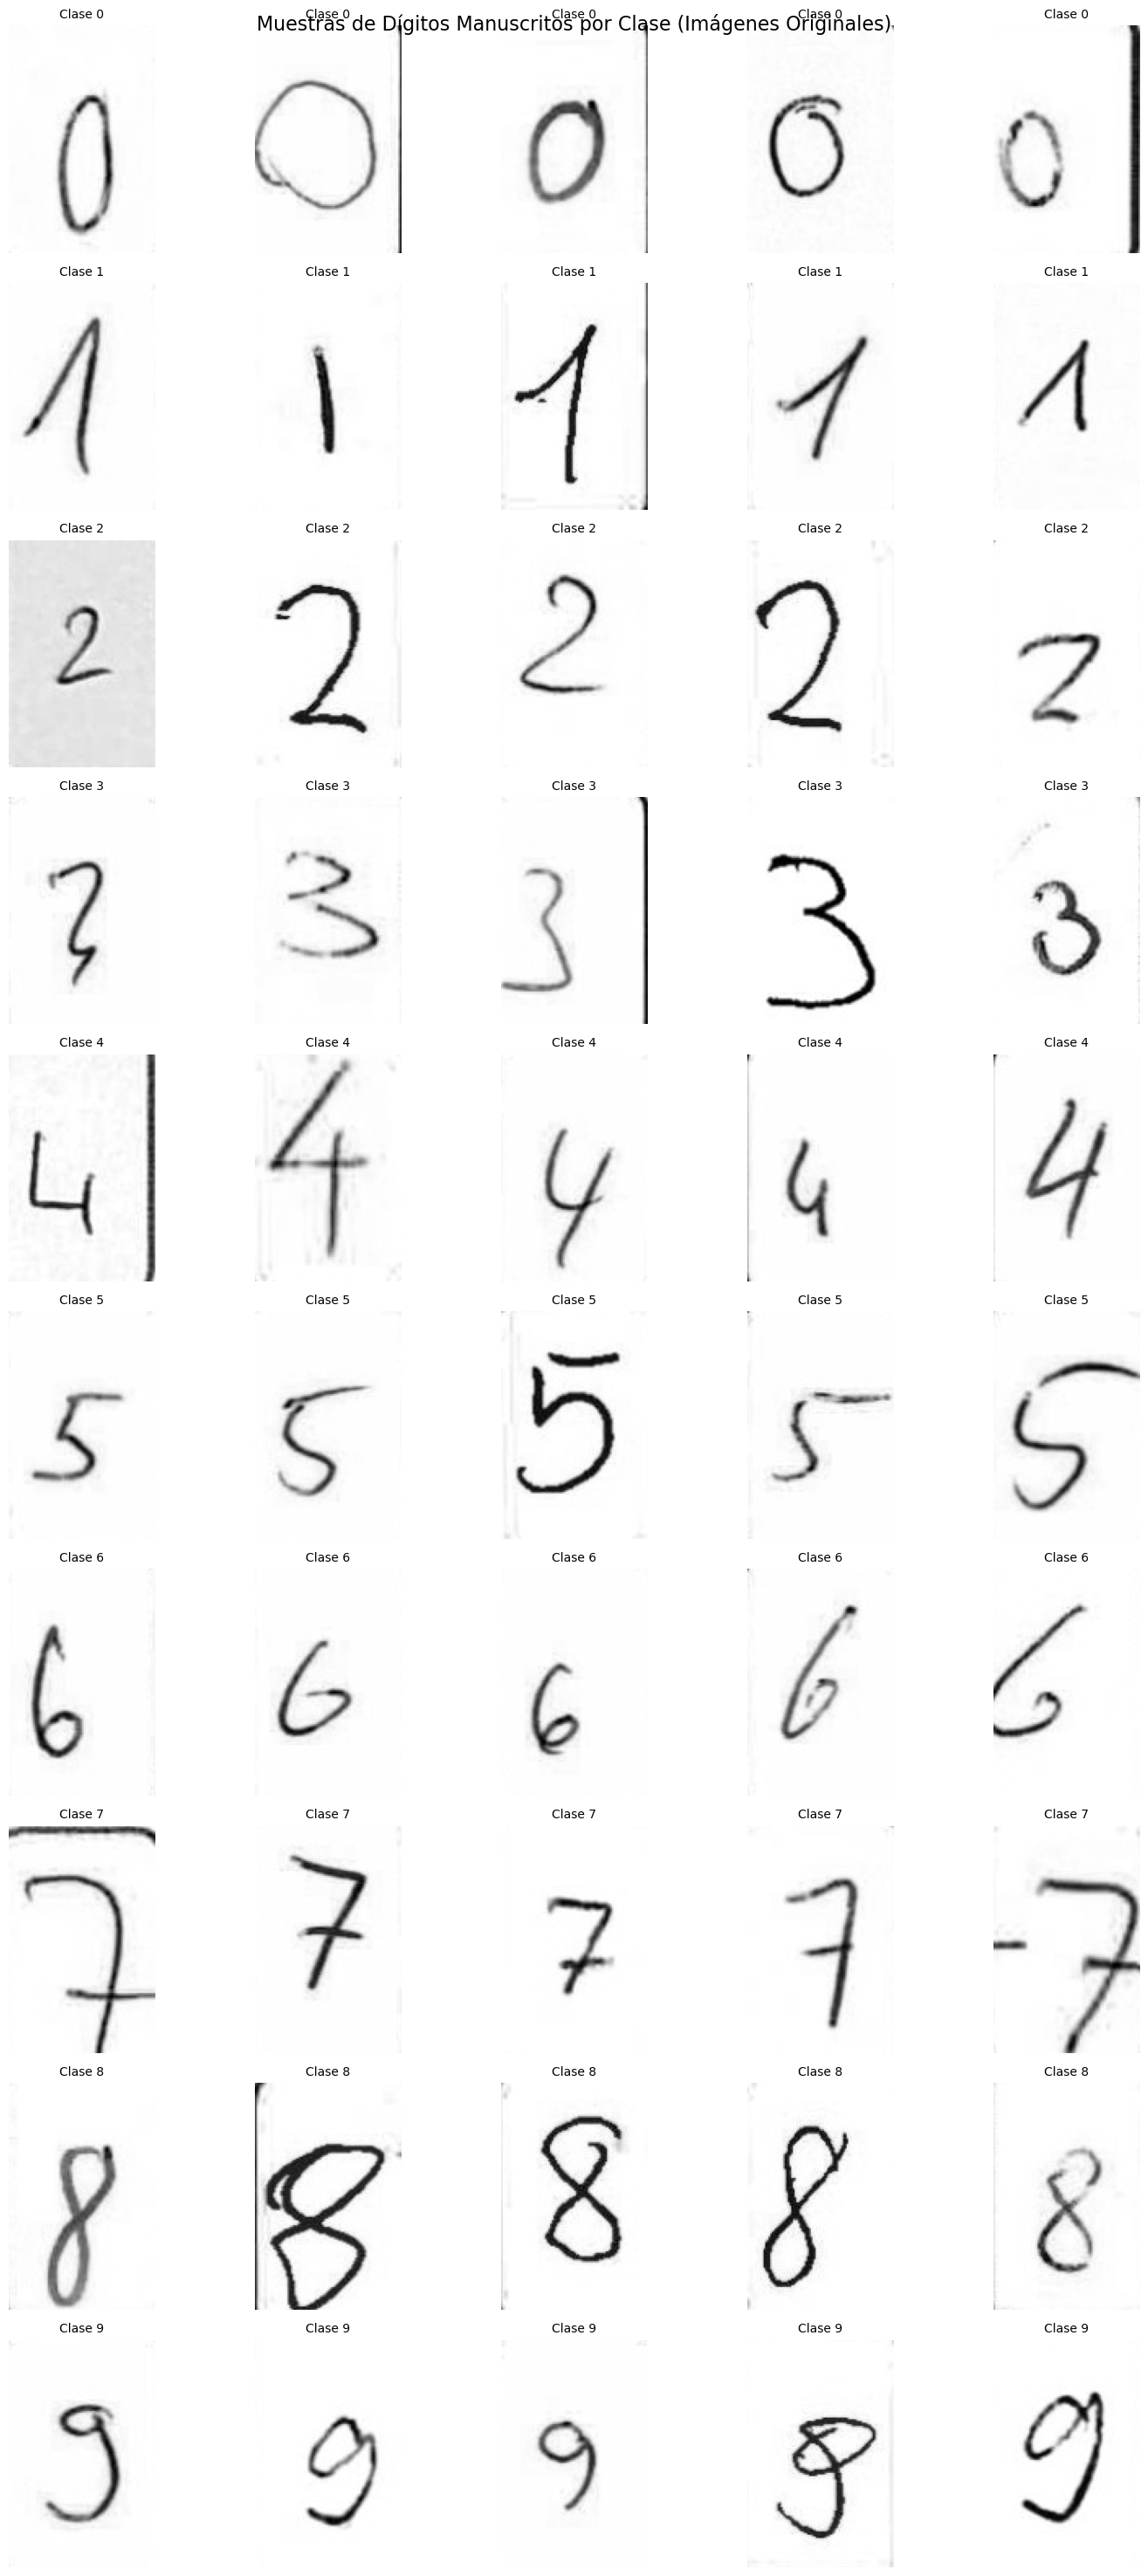

In [10]:

print("\n1. CARGANDO Y VISUALIZANDO DATOS...")
# Crear diccionario para almacenar imágenes por dígito
digit_images = {}
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        digit_images[str(label)] = image_files
    else:
        print(f"Advertencia: Carpeta {folder_path} no encontrada")

# Visualizar 5 imágenes por clase (ORIGINALES)
print("Visualizando muestras de cada clase (imágenes originales)...")
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
for label, image_files in digit_images.items():
    if len(image_files) >= 5:
        chosen_images = np.random.choice(image_files, 5, replace=False)
        for i, image_file in enumerate(chosen_images):
            image_path = os.path.join(data_dir, label, image_file)
            try:
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    ax = axes[int(label), i]
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Clase {label}", fontsize=10)
                    ax.axis('off')
            except Exception as e:
                print(f"Error leyendo imagen {image_path}: {e}")

plt.suptitle("Muestras de Dígitos Manuscritos por Clase (Imágenes Originales)", fontsize=16)
plt.tight_layout()
plt.show()


2. ANALIZANDO DISTRIBUCIÓN DE CLASES...


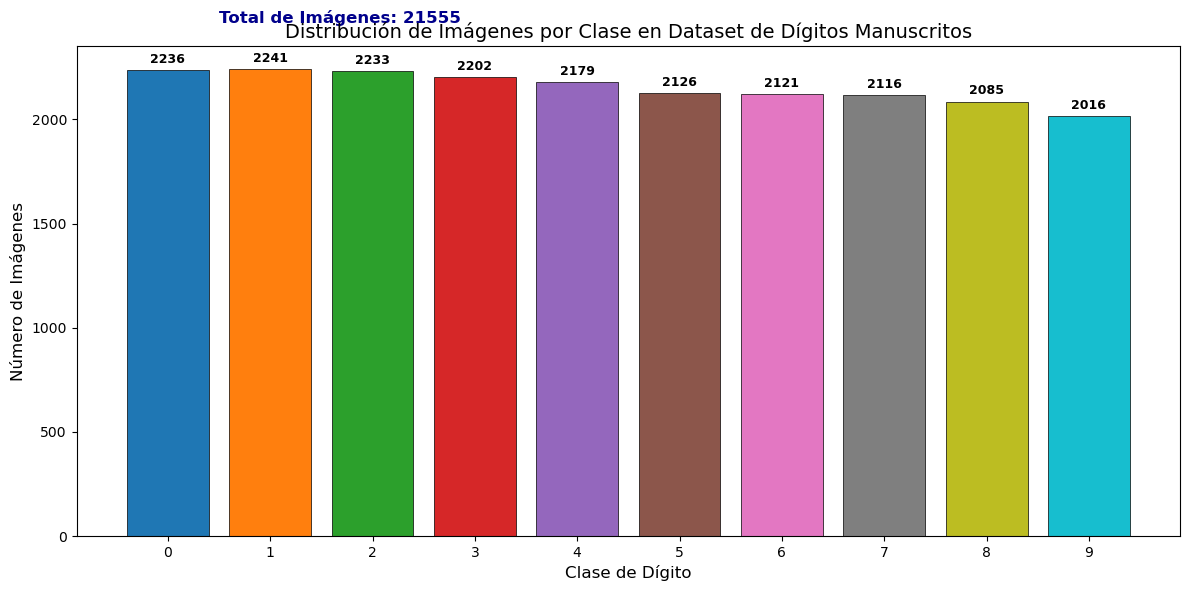

Total de imágenes en el dataset: 21555
Clase 0: 2236 imágenes
Clase 1: 2241 imágenes
Clase 2: 2233 imágenes
Clase 3: 2202 imágenes
Clase 4: 2179 imágenes
Clase 5: 2126 imágenes
Clase 6: 2121 imágenes
Clase 7: 2116 imágenes
Clase 8: 2085 imágenes
Clase 9: 2016 imágenes


In [11]:

print("\n2. ANALIZANDO DISTRIBUCIÓN DE CLASES...")
# Contar imágenes por clase
digit_counts = {}
total_images = 0
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        digit_counts[str(label)] = len(image_files)
        total_images += len(image_files)

# Crear gráfico de barras de distribución
labels = list(digit_counts.keys())
counts = list(digit_counts.values())
colors = plt.cm.tab10(range(10))

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color=colors, edgecolor='black', linewidth=0.5)
plt.xlabel("Clase de Dígito", fontsize=12)
plt.ylabel("Número de Imágenes", fontsize=12)
plt.title("Distribución de Imágenes por Clase en Dataset de Dígitos Manuscritos", fontsize=14)
plt.xticks(labels)

# Añadir estadísticas
plt.text(0.5, max(counts) * 1.1, f"Total de Imágenes: {total_images}", 
         ha='left', fontsize=12, color='darkblue', weight='bold')

# Añadir valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + max(counts)*0.01, 
             int(yval), ha='center', va='bottom', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

print(f"Total de imágenes en el dataset: {total_images}")
for label, count in digit_counts.items():
    print(f"Clase {label}: {count} imágenes")


### **Análisis de la distribución de las clases**

Al analizar la distribución de las clases, se observa que el dataset contiene un total de **21,555 imágenes** distribuidas en **10 clases** (dígitos del 0 al 9).

Como se ha señalado, la distribución es **bastante balanceada** y no existen diferencias significativas entre la cantidad de datos por clase. Esto es ideal para el entrenamiento de modelos, ya que reduce el riesgo de sesgo hacia alguna clase específica.

## **3. Preprocesamiento y preparación de los datos**

Las siguientes estrategias fueron aplicadas para preparar los datos:

- **Normalización:**  
  Se escalan los valores de píxeles entre 0 y 1 dividiendo por 255.

- **División en entrenamiento y prueba:**  
  Se dividió el conjunto en **80% para entrenamiento** y **20% para prueba**.

- **Codificación (cuando aplica):**  
  No necesaria aquí porque las etiquetas ya están codificadas como enteros.

- **Balanceo de clases:**  
  Se verificó que las clases estuvieran balanceadas. Si no lo estuvieran, se podría aplicar **sobremuestreo (SMOTE)** o **submuestreo**.

- **Reducción de dimensiones:**  
  Mediante **PCA** para acelerar algunos algoritmos, si se considera conveniente.

In [14]:
import os
import numpy as np
from PIL import Image, ImageOps
from scipy.ndimage import center_of_mass
from collections import Counter
import matplotlib.pyplot as plt


def procesar_imagen(ruta_imagen):
    try:
        img = Image.open(ruta_imagen).convert('L')         # Escala de grises
        img = ImageOps.invert(img)                         # Fondo negro, dígito blanco

          # 🔧 0. Recorte de 4 píxeles de todos los bordes
        ancho, alto = img.size
        img = img.crop((10, 10, ancho - 10, alto - 10))

        # 1. Mejorar contraste
        from PIL import ImageEnhance, ImageFilter
        img = ImageEnhance.Contrast(img).enhance(2.0)

        # 2. Recorte del dígito
        img_array_raw = np.array(img)
        coords = np.argwhere(img_array_raw < 255)
        if coords.size > 0:
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img = img.crop((x0, y0, x1, y1))

        # 3. Suavizado ligero
        img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

        # 4. Redimensionar el contenido a 20x20
        img = img.resize((20, 20), Image.LANCZOS)

        # 5. Añadir padding para centrar en imagen 28x28
        nueva_img = Image.new('L', (28, 28), color=0)
        nueva_img.paste(img, (4, 4))  # Centro aproximado

        # 6. Normalizar y centrar por masa
        img_array = np.array(nueva_img) / 255.0
        cy, cx = center_of_mass(img_array)
        shift_x = int(14 - cx)
        shift_y = int(14 - cy)
        img_array = np.roll(np.roll(img_array, shift_x, axis=1), shift_y, axis=0)

        return img_array.flatten()

    except Exception as e:
        print(f"Error al procesar imagen {ruta_imagen}: {e}")
        return None



# Recorrer carpetas y cargar imágenes procesadas
X = []
y = []

for etiqueta in os.listdir(data_dir):
    carpeta = os.path.join(data_dir, etiqueta)
    if os.path.isdir(carpeta):
        for archivo in os.listdir(carpeta):
            ruta_imagen = os.path.join(carpeta, archivo)
            vector = procesar_imagen(ruta_imagen)
            if vector is not None:
                X.append(vector)
                y.append(int(etiqueta))

X = np.array(X)
y = np.array(y)

print("Número de imágenes procesadas:", len(X))
print("Shape de X:", X.shape)
# --- Balance de clases ---
conteo_clases = Counter(y)

# Imprimir conteo por clase
print("\nBalance de clases:")
for clase, cantidad in sorted(conteo_clases.items()):
    print(f"Clase {clase}: {cantidad} imágenes")

Número de imágenes procesadas: 21555
Shape de X: (21555, 784)

Balance de clases:
Clase 0: 2236 imágenes
Clase 1: 2241 imágenes
Clase 2: 2233 imágenes
Clase 3: 2202 imágenes
Clase 4: 2179 imágenes
Clase 5: 2126 imágenes
Clase 6: 2121 imágenes
Clase 7: 2116 imágenes
Clase 8: 2085 imágenes
Clase 9: 2016 imágenes


### Reducción de dimensionalidad con PCA

Para facilitar la visualización y acelerar el entrenamiento de los modelos, se aplicó **PCA (Análisis de Componentes Principales)**. Esta técnica permite reducir el número de características manteniendo la mayor parte de la varianza del conjunto de datos. Así, se logra una representación más compacta y eficiente de las imágenes de dígitos manuscritos.

In [15]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Reducción con PCA al 95%
print("\nAplicando PCA para reducción de dimensionalidad...")
pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
X_pca = pca.fit_transform(X)

print(f"Dimensiones originales: {X.shape}")
print(f"Dimensiones después de PCA: {X_pca.shape}")
print(f"Varianza explicada acumulada: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Número de componentes seleccionados: {pca.n_components_}")

# 2. Cálculo de PCA completo para la gráfica
pca_full = PCA()
pca_full.fit(X)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)



Aplicando PCA para reducción de dimensionalidad...
Dimensiones originales: (21555, 784)
Dimensiones después de PCA: (21555, 165)
Varianza explicada acumulada: 0.9502
Número de componentes seleccionados: 165
Dimensiones originales: (21555, 784)
Dimensiones después de PCA: (21555, 165)
Varianza explicada acumulada: 0.9502
Número de componentes seleccionados: 165


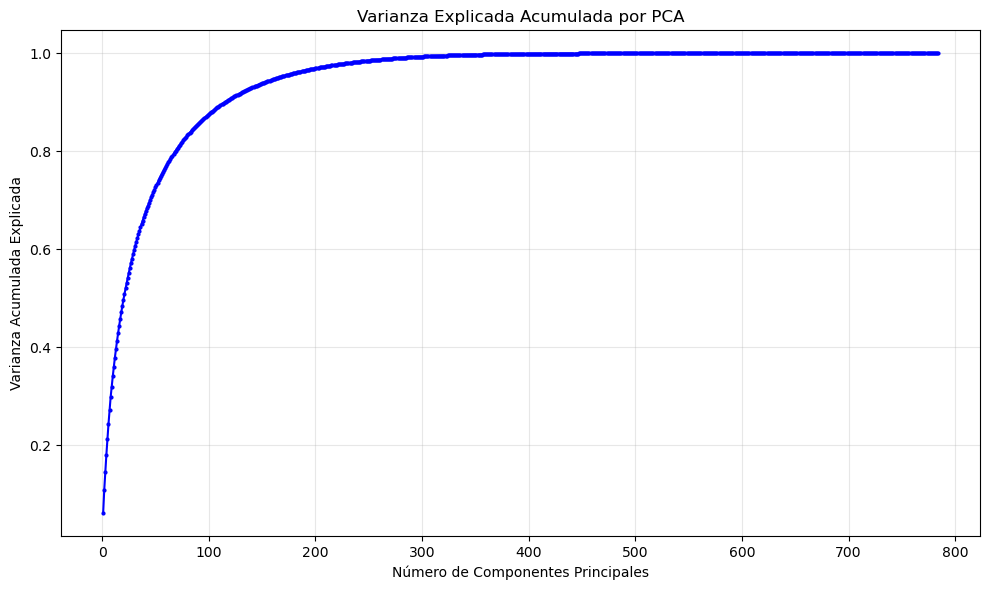

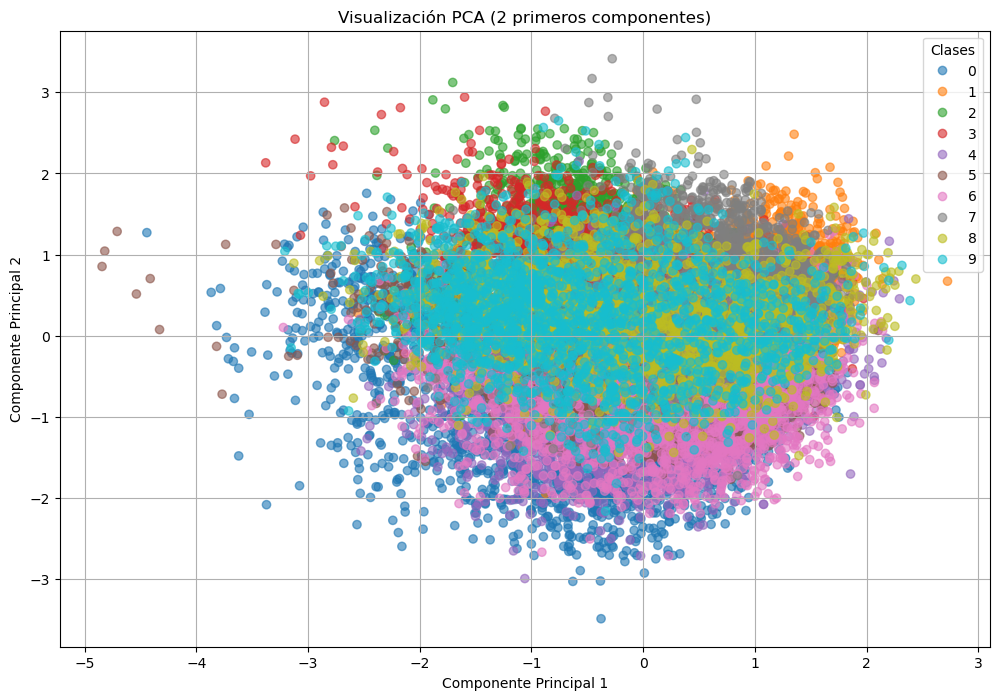

In [16]:
# 3. Visualización de varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance,
         marker='o', linestyle='-', color='b', markersize=2)
#plt.axhline(y=0.85, color='r', linestyle='--', alpha=0.8, label='85% objetivo')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.grid(True, alpha=0.3)
#plt.legend()
plt.tight_layout()
plt.show()

# 4. Visualización con los primeros dos componentes (si existen)
if X_pca.shape[1] >= 2:
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title('Visualización PCA (2 primeros componentes)')
    plt.legend(*scatter.legend_elements(), title='Clases')
    plt.grid(True)
    plt.show()
else:
    print("No hay suficientes componentes para graficar en 2D.")

# 5. Guardar resultados
np.save('X_pca_reduced.npy', X_pca)
np.save('y_labels.npy', y)

### División de los datos: entrenamiento y prueba

Para evaluar el rendimiento de los modelos de manera objetiva, el conjunto de datos se divide en dos subconjuntos:

- **Entrenamiento (80%)**: Utilizado para ajustar los parámetros de los modelos.
- **Prueba (20%)**: Reservado para validar la capacidad de generalización del modelo sobre datos no vistos.

Esta división garantiza que los resultados obtenidos reflejen el desempeño real del modelo y ayudan a prevenir el sobreajuste.

In [ ]:
print("\n DIVIDIENDO DATOS EN ENTRENAMIENTO Y PRUEBA...")
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nDistribución en entrenamiento:")
for digit, count in zip(unique_train, counts_train):
    print(f"Clase {digit}: {count} muestras")


## **4. Entrenamiento de modelos y ajuste de hiperparámetros**

Se entrenaron los siguientes modelos utilizando **GridSearchCV** con validación cruzada:

- **Regresión logística multiclase (One-vs-Rest):**  
  Ajustando los parámetros **C** y **solver**.

- **Árboles de decisión:**  
  Ajustando **max_depth**, **min_samples_split** y **criterion**.

- **Random Forest:**  
  Optimizando **n_estimators**, **max_features** y **max_depth**.

- **Redes neuronales (MLPClassifier):**  
  Búsqueda sobre **hidden_layer_sizes**, **activation**, **alpha** y **learning_rate_init**.

Cada modelo fue evaluado usando **validación cruzada (cv=5)** para evitar sobreajuste y seleccionar los mejores hiperparámetros.